In [1]:
# NAME = ABDUL HANAN
# STUDENT ID = 30340284

### Part A. Document Clustering <br>
In this part, you solve a document clustering problem using unsupervised
learning algorithms (i.e., soft and hard Expectation Maximization) for
document clustering.

#### Importing Libraries to be used

In [2]:
#install some packages:
#install.packages('tm')
#install.packages('SnowballC')  
library(tm)
library(SnowballC)
library(ggplot2)

Warning message:
"package 'tm' was built under R version 3.6.3"Loading required package: NLP
Warning message:
"package 'SnowballC' was built under R version 3.6.3"Warning message:
"package 'ggplot2' was built under R version 3.6.3"
Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



#### Question 1 [EM for Document Clustering]

1. Derive Expectation and Maximization steps of the hard-EM algorithm for Document Clustering, show your work in your submitted PDF report. In particular, include all model parameters that should be learnt and the exact expression (using the same math convention that we saw in the Module 4) that should be used to update these parameters during the learning process (ie., E step, M step and assignments).

#### Derivation has been given in the PDF report

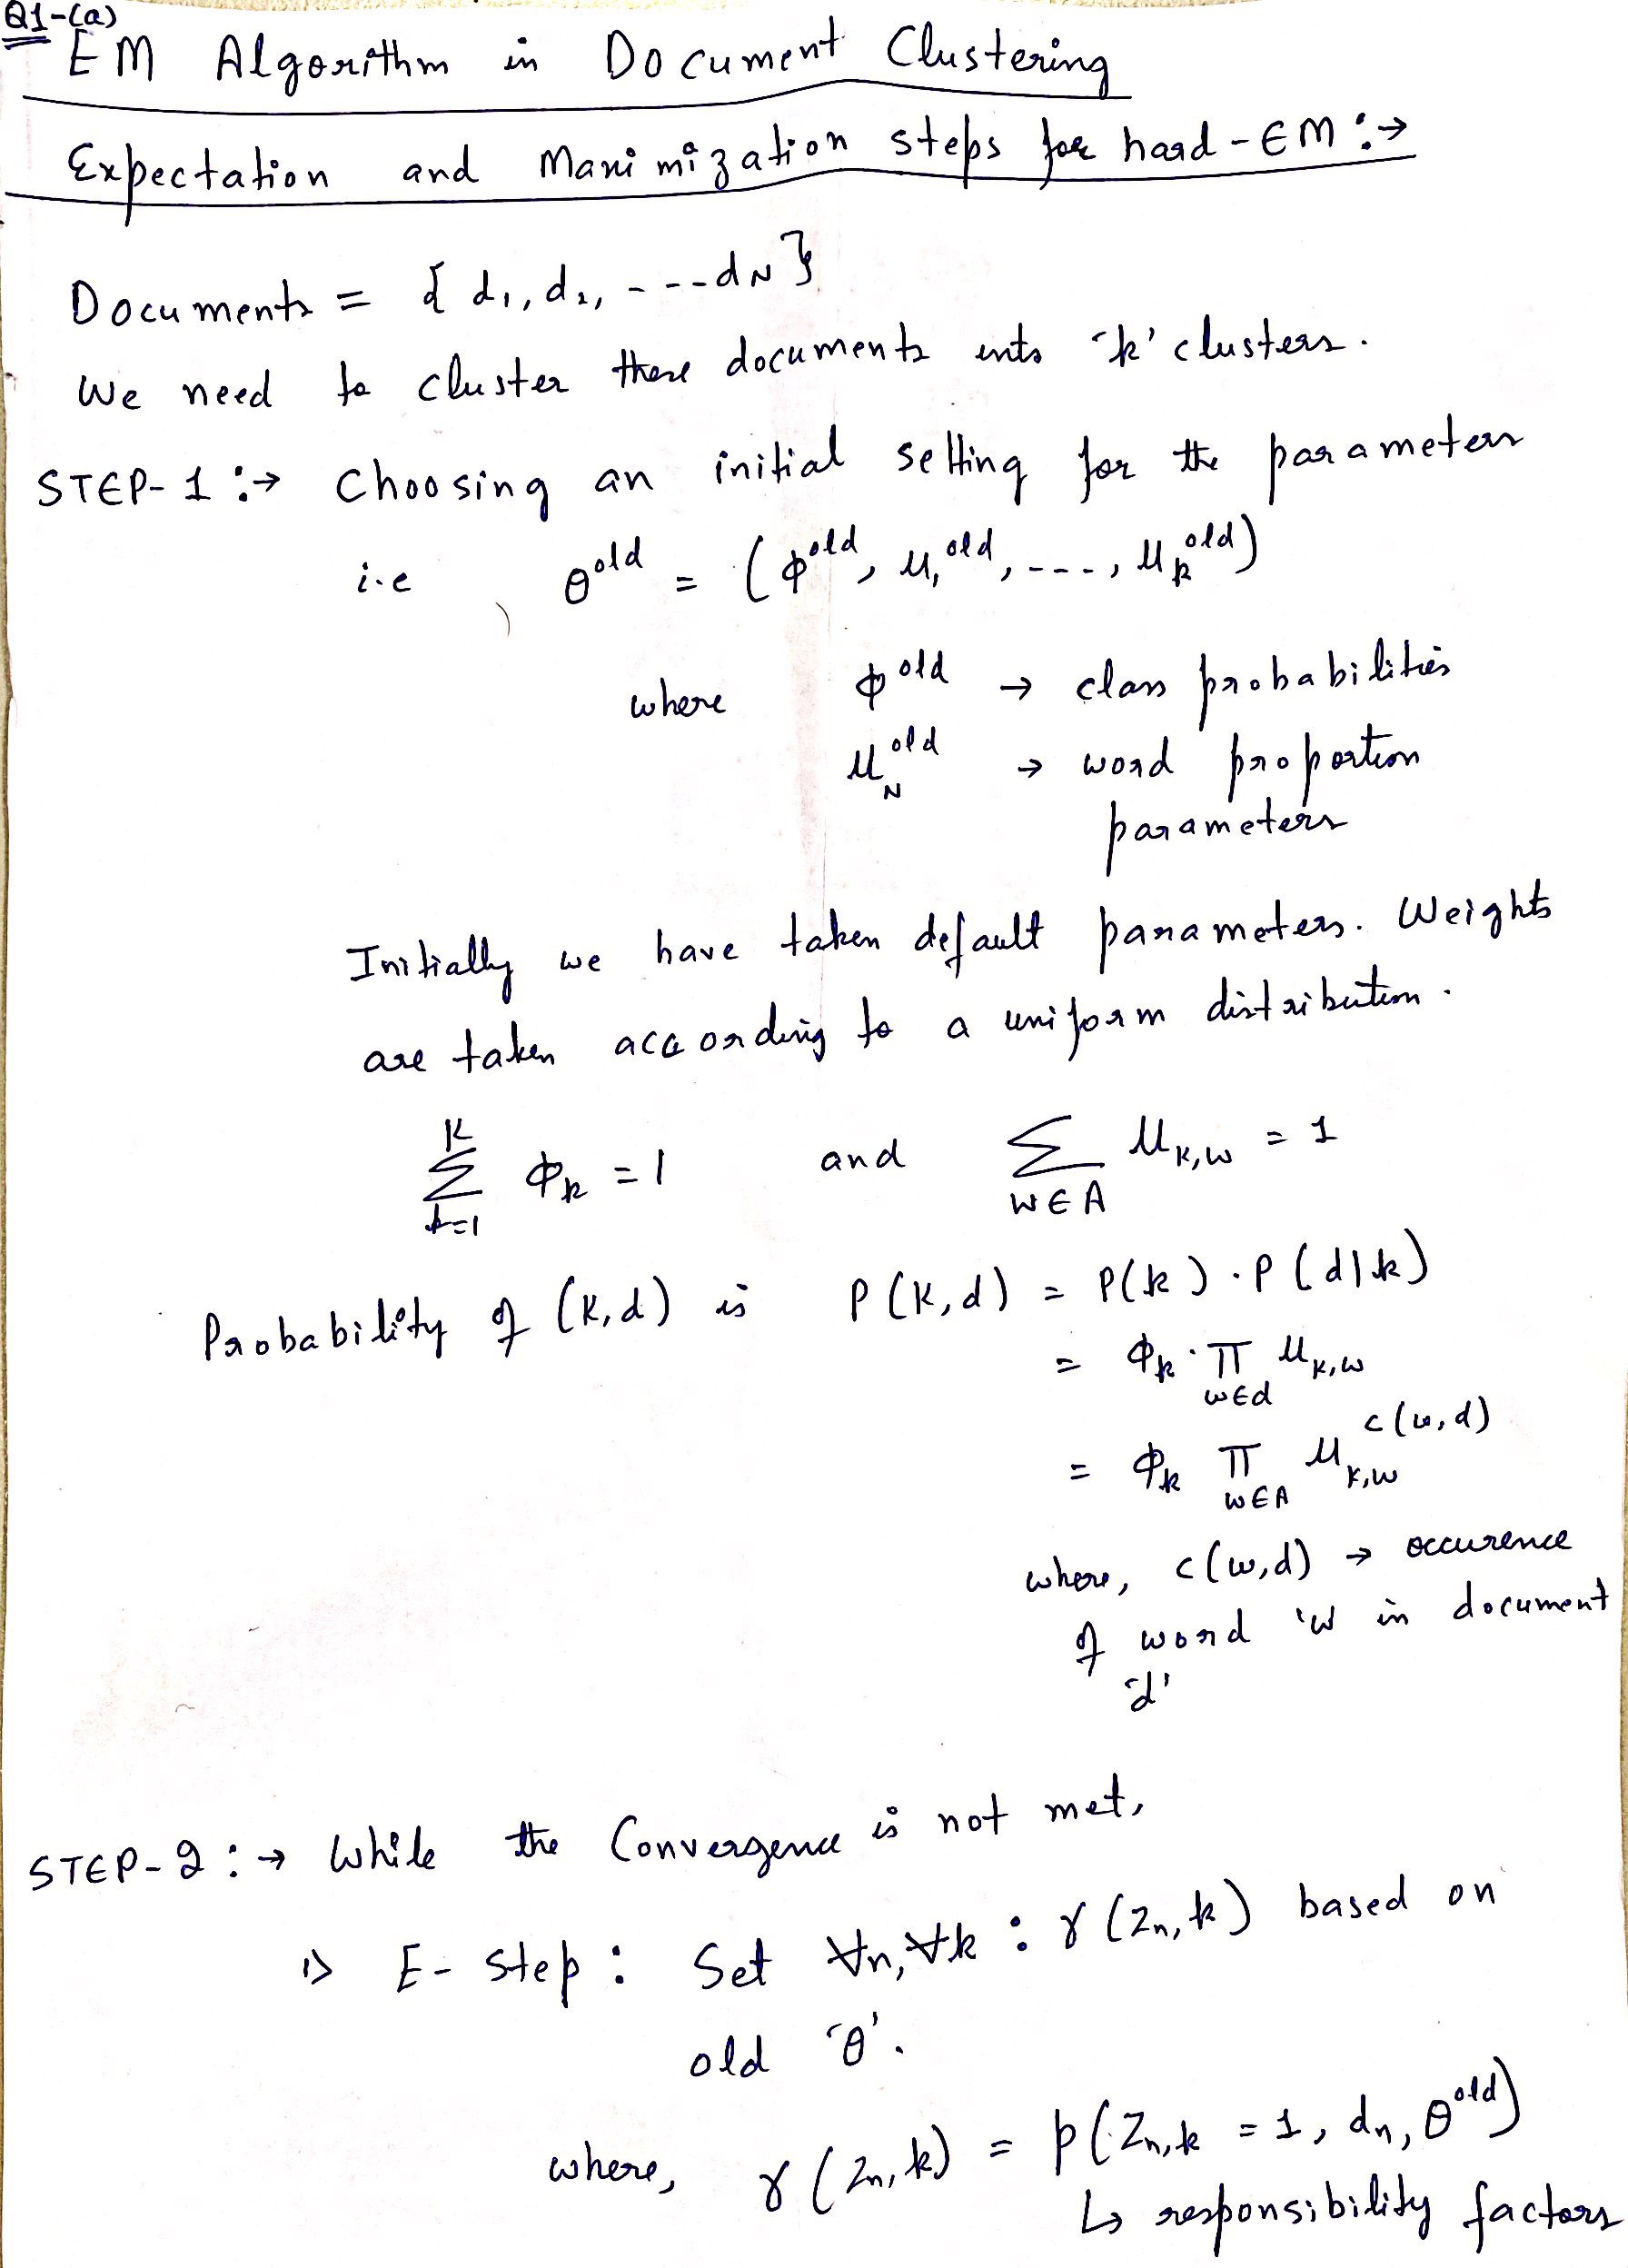

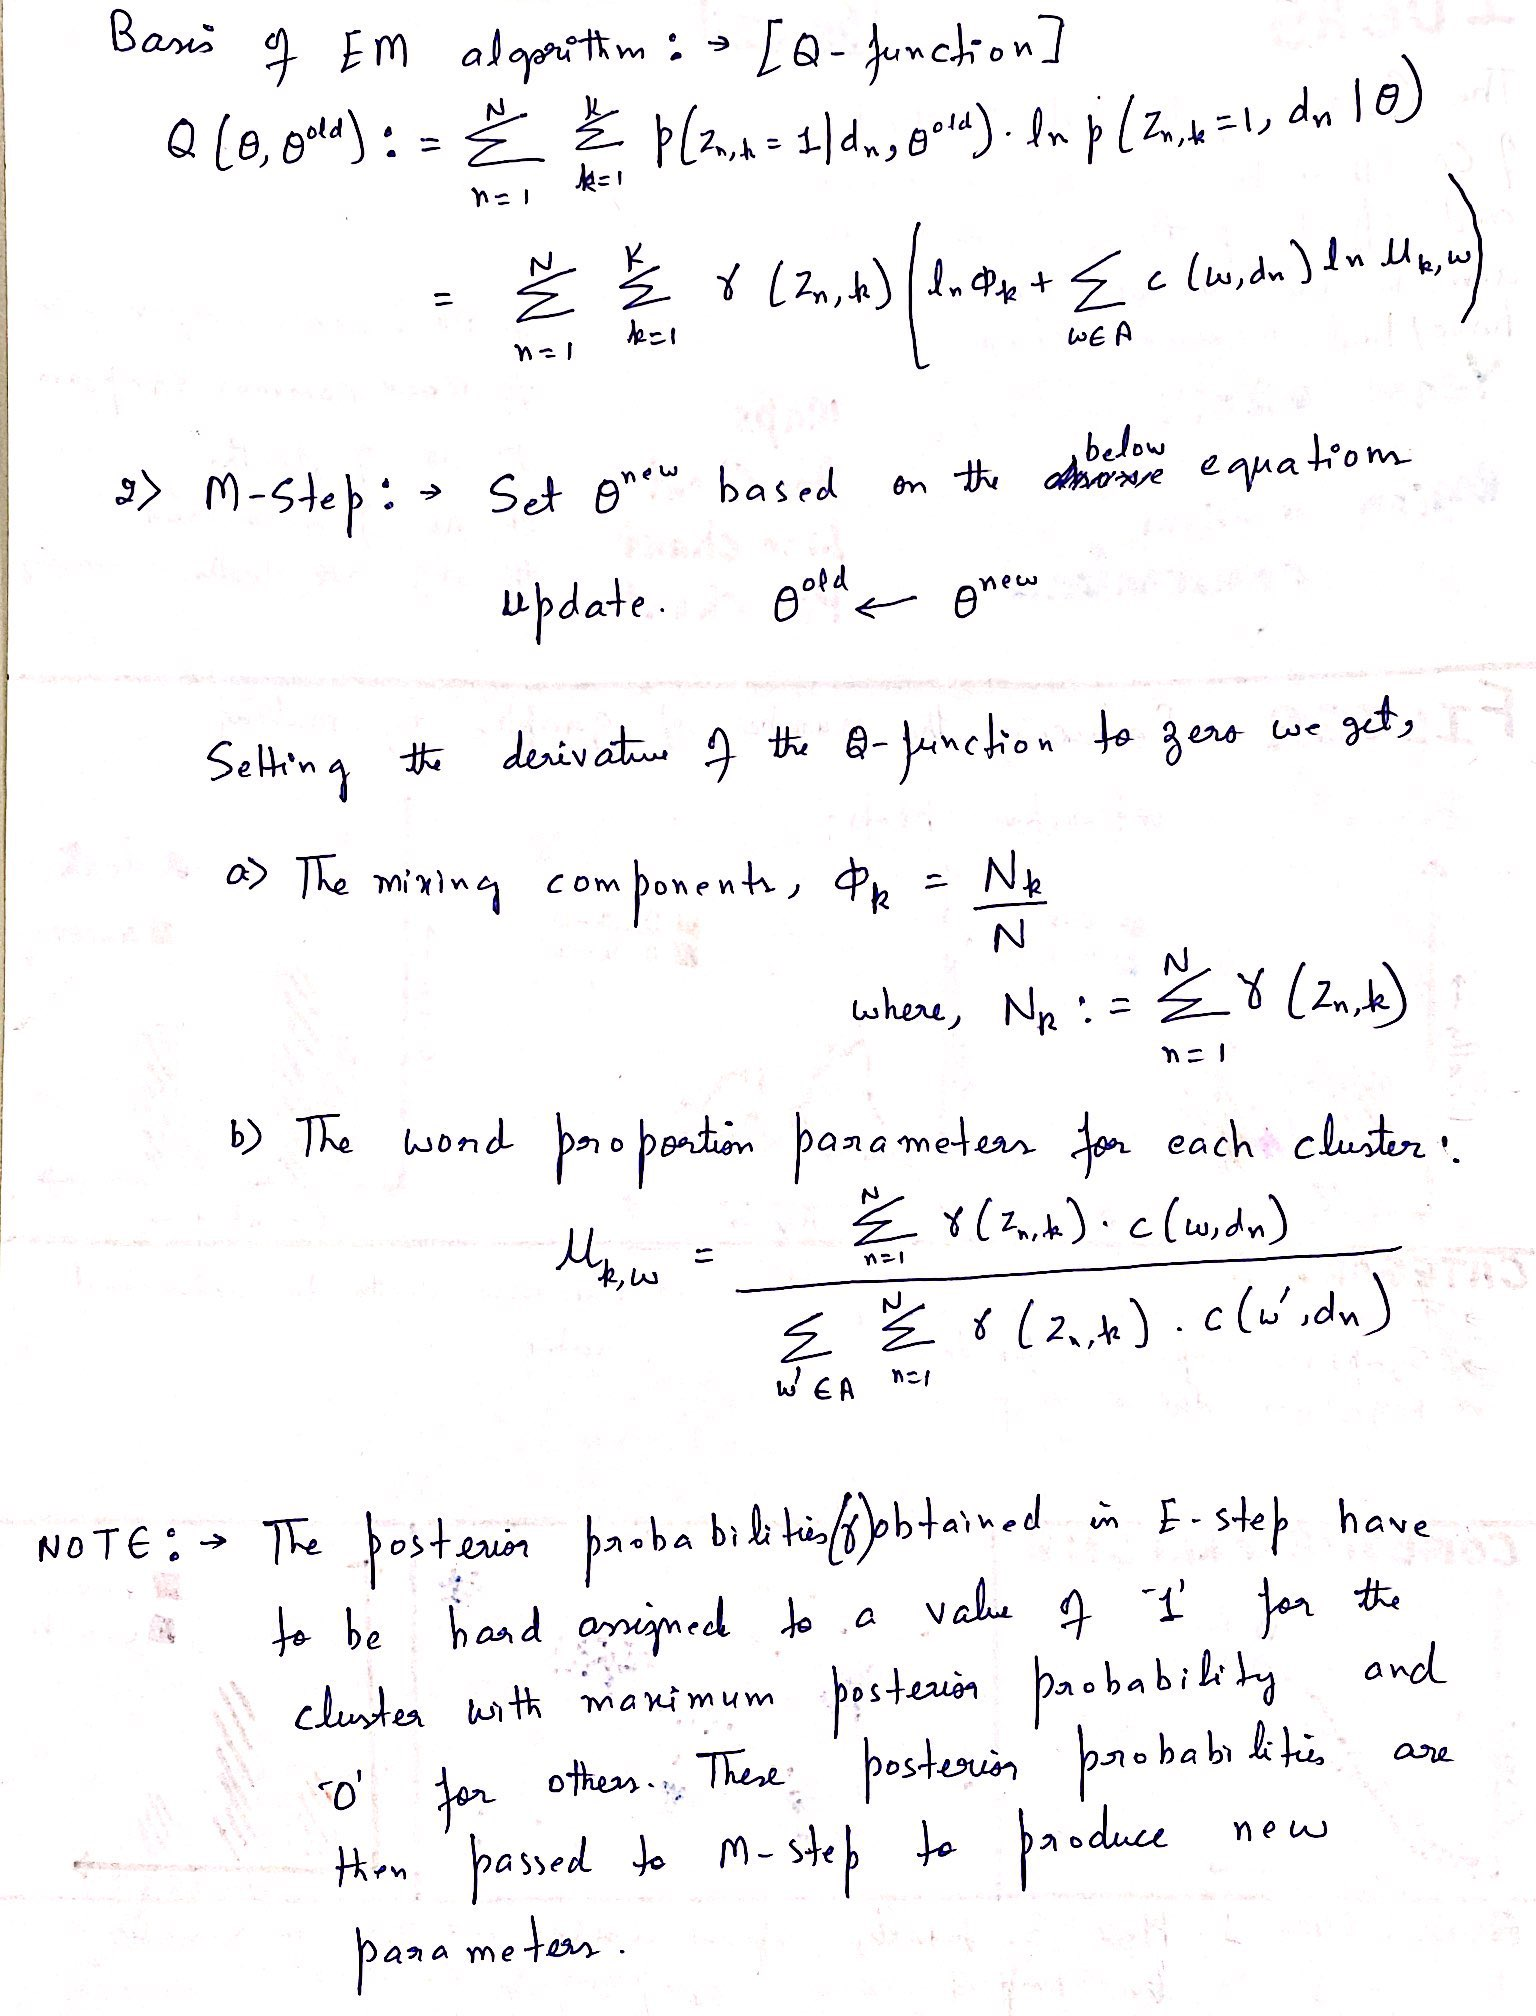

2.  Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of Module 4). Please provide enough comments in your submitted code.

### HARD EM E-Step for Document Clustering

In [3]:
# this function currently implements the E-step of the Hard-EM
E.step_hard <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }

  } 
  # hard assignments:
  max.gamma <- gamma==apply(gamma, 1, max) 
  gamma[max.gamma] <- 1   #setting value =1 for cluster with max posterior prob
  gamma[!max.gamma] <- 0 
  return (gamma)
}

### SOFT EM  E-Step for Document Clustering

In [4]:
##---   --------------------------------------------
# this function currently implements the E-step of the soft-EM
E.step_soft <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,]) # logSum() function to perform normalisation
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}

#### Below we have defined a logSum() function for Normalisation

In [5]:
## --- helper function ---------------
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

### M Step for Document Clustering

In [6]:
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
  eps = 1e-10
  # updating model$rho and model$mu
  for (k in 1:K) {
      
      model$rho[k] = sum(gamma[,k])/N  # updating mixing components
      
      model$mu[k,] = colSums(gamma[,k] * t(counts))     # updating word proportion parameters
  }
    model$mu <- model$mu + eps   # adding an eps small value
    model$mu <- model$mu/rowSums(model$mu)  #word proportion

  # Return the result
  return (model) # returning model with updated parameters
}

3. Load Task2A.txt file and necessary libraries (if needed, perform text preprocessing similar to what we did in Activity 4.2), set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

**Below we have defined a function that takes file name as input and performs the text preprocessing**

In [7]:
# reading the data
read.data <- function(file.name='Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts
                           
  # create uid and text labels for DataframeSource() function
  uid = paste0("doc_",formatC(1:2373,width=5,format="d",flag="0"))
  docs = data.frame(doc_id=uid,text = unlist(lapply(docs, function(x) x[2])))   
  
  
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

#### Function to initilize model parameters rho[each class probability] and mu[Word proportion parameter] randomly <br>

* rho is initialised as equal class probabilities
* mu is obtained from a uniform distribution

In [8]:
##--- Initialize model parameters randomly --
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}

#### The training objective function

In [9]:
##--- n --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
#     print(lprob)
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}

### EM for Document Clustering - using SOFT EM <br>
1. INPUTS:
    * counts: word count matrix
    * K: the number of clusters
2. OUTPUTS:
    * model: a list of model parameters

In [10]:
EM_soft <- function(counts, K=4, max.epoch=10, seed=123456){

  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K) #gamma = posterior prob
    
#   print(train_obj(model,counts))
    
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step_soft(gamma, model, counts)
#     print(gamma)
    # M Step
    model <- M.step(gamma, model, counts)
   
#     print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

### EM for Document Clustering - using HARD EM <br>
1. INPUTS:
    * counts: word count matrix
    * K: the number of clusters
2. OUTPUTS:
    * model: a list of model parameters

In [11]:
EM_hard <- function(counts, K=4, max.epoch=10, seed=123456){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K) #gamma = posterior prob
    
#   print(train_obj(model,counts))
    
  # Build the model
  for(epoch in 1:max.epoch){
    
    # E Step
    gamma <- E.step_hard(gamma, model, counts)
#     print(gamma)
    # M Step
    model <- M.step(gamma, model, counts)
   
#     print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

### Main Body

In [12]:
# Reading documents 
## Note: sample.size=0 means all read all documents!
data <- read.data(file.name='Task2A.txt', sample.size=0, seed=100, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat  

# calling the EM algorithm on the data

res_soft <- EM_soft(counts, K=4, max.epoch=5)

res_hard <- EM_hard(counts, K=4, max.epoch=5)

4. Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM in the same way we did in Activity 4.2. Then, visualize the obtained clusters with different colors where x and y axes are the first two principal components (similar to Activity 4.2). Attach the plots to your PDF report and report how and why the hard and soft-EM are different, based on your plots in the report.

### Cluster Visualization
#### Below function performs Principle Component Analysis and plots the input word document matrix colored according to our predicted labes 

In [13]:
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}

### Visualization - Soft EM

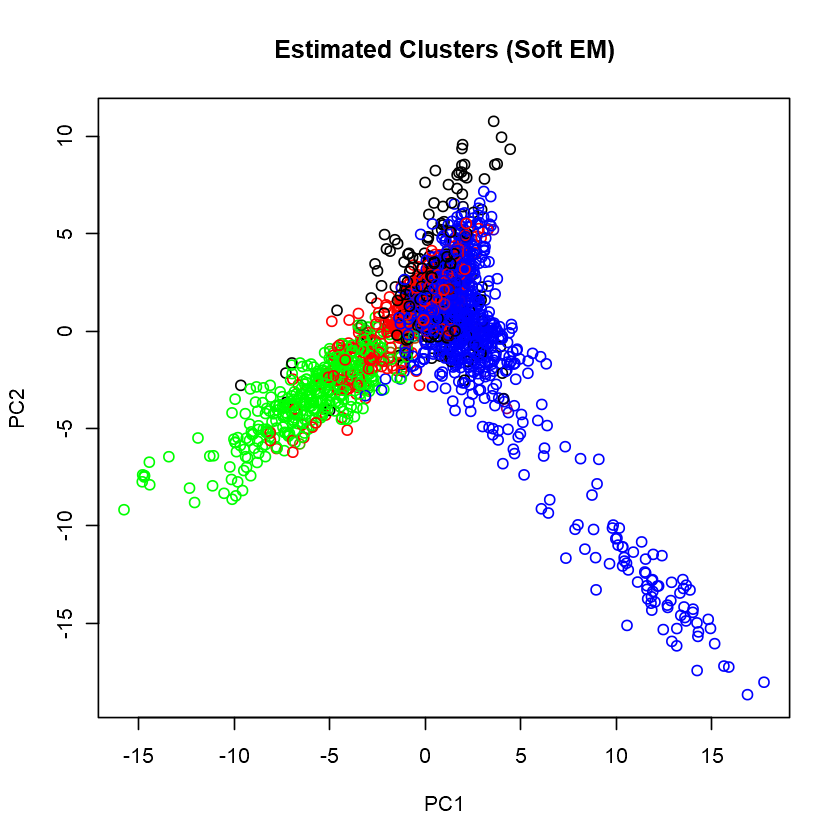

In [14]:
# ## find the culster with the maximum probability (since we have soft assignment here)
# label.hat_soft <- apply(res_soft$gamma, 1, which.max) 

# ## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

# # ## visualize the estimated clusters
cluster.viz(t(counts),rgb(res_soft$gamma), 'Estimated Clusters (Soft EM)')

# # ## visualize the real clusters
# cluster.viz(t(counts), factor(data$label), 'Real Clusters')

### Visualization - Hard EM

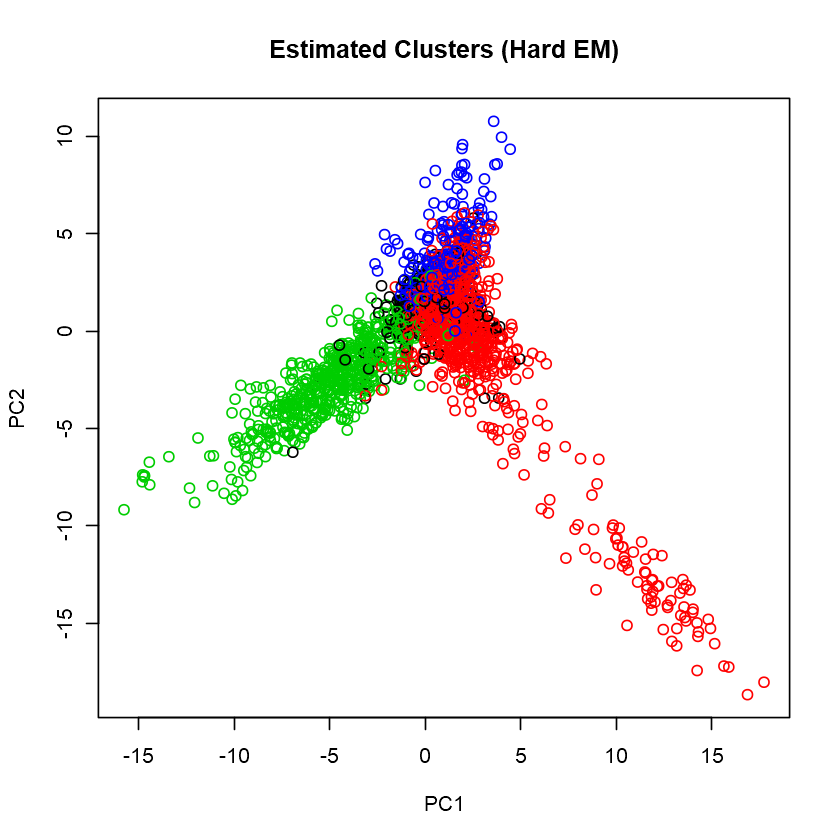

In [15]:
# ## find the culster with the maximum probability (since we have soft assignment here)
label.hat_hard <- apply(res_hard$gamma, 1, which.max) 
# ## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

# ## visualize the estimated clusters
cluster.viz(t(counts), label.hat_hard, 'Estimated Clusters (Hard EM)')

# ## visualize the real clusters
# cluster.viz(t(counts), factor(data$label), 'Real Clusters')

For the SOFT EM algorithm the datapoints are assigned into classes according to their gamma values i.e. a particular data point can be alloted to more than one clusters thus expalining the color discrepancies. <br>
        NOTE: In SOFT EM plot we do not see much color mixing as the distribution of our gamma values assigned to each data point for each cluster is greater much large for a paticular cluster and has small values for other clusters. In many cases the gamma value is 1 and 0 for other clusters thus justifying the many single color data points. <br> <br>

For the HARD EM, each data point has been alloted to a particular cluster, depending upon the argmax(gamma) which is assigned as 1. Thus we can see bold and single colors for each data point